In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

#from utils import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print (device)

cuda:0


## Data preprocessing

In [2]:
data = np.genfromtxt('./train.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_y = data[:,0]
data = np.delete(data, (0), axis=1)
data_np_x = data / 255


pos = int(data_np_x.shape[0] * 0.9)

train_np_y = data_np_y[:pos]
train_np_x = data_np_x[:pos]
test_np_y = data_np_y[pos:]
test_np_x = data_np_x[pos:]

print ("Y: {}".format(train_np_y[:10]))

Y: [1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [3]:
print (data_np_x.shape, data_np_y.shape)
print (train_np_x.shape, train_np_y.shape)
print (test_np_x.shape, test_np_y.shape)

(42000, 784) (42000,)
(37800, 784) (37800,)
(4200, 784) (4200,)


In [4]:
print (test_np_x.shape, test_np_y.shape)

(4200, 784) (4200,)


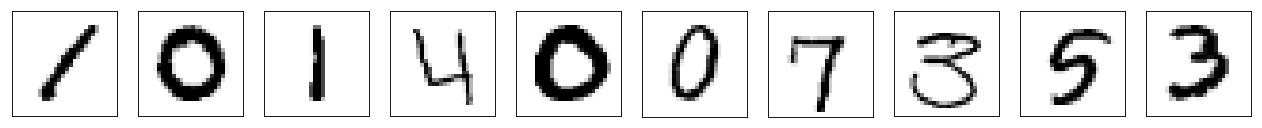

[1. 0. 1. 4. 0. 0. 7. 3. 5. 3.]


In [5]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = train_np_x[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (train_np_y[:10])

In [6]:
def normalize(x):
    x = (x - 0.1307) / 0.3081    
    return x

In [7]:
train_x = torch.Tensor(np.expand_dims(normalize(train_np_x), axis=1))
train_y = torch.LongTensor(train_np_y)

test_x = torch.Tensor(np.expand_dims(normalize(test_np_x), axis=1))
test_y = torch.LongTensor(test_np_y)

## Neural network

In [8]:
def loader(x, y, batch_size=32):
    for i in range(0, x.size(0) - 1, batch_size):
        data = x[i:i+batch_size]
        if data.shape[0] == batch_size:
            data = data.reshape(batch_size, 1, 28, 28)
            targets = y[i:i+batch_size]

            yield data, targets
    

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []        
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [11]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=5e-5, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 32, 3], bn=batchnorm)
        self._conv2 = ConvLayer([32, 64, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([64*7*7, 512, 10], dropout=dropout)
        
        self.lr = lr
        self.lr_base = lr
        self.l2 = l2
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):        
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [12]:
def shuffle_data(X, y):
    r = np.random.permutation(len(y))
    return X[r], y[r]

In [13]:
def train(epoch, models, log=None):    
    for model in models.values():
        model.lr = model.lr_base * (100 / (epoch + 100))        
        model.optim = optim.Adam(model.parameters(), lr=model.lr, weight_decay=model.l2)
    print ("LR: {}".format(models['bn'].lr))    
    train_size = len(train_x)
    
    for batch_idx, (data, target) in enumerate(loader(train_x, train_y)):        
        for model in models.values():                             
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [14]:
def test(models, log=None):
    test_size = len(test_x)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(test_x, test_y):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [15]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [16]:
models = {'bn': Net(True), 'drop': Net(False, True), 'bndrop': Net(True, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [18]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train_x, train_y = shuffle_data(train_x, train_y)    
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

LR: 4.950495049504951e-05
Train Epoch: 1 [0/37800 (0%)]	Losses bn: 0.279402 drop: 0.743752 bndrop: 0.445788 plain: 0.524532
Train Epoch: 1 [6400/37800 (1%)]	Losses bn: 0.144145 drop: 0.583169 bndrop: 0.278166 plain: 0.441812
Train Epoch: 1 [12800/37800 (1%)]	Losses bn: 0.182827 drop: 0.556349 bndrop: 0.314393 plain: 0.438191
Train Epoch: 1 [19200/37800 (2%)]	Losses bn: 0.063010 drop: 0.299776 bndrop: 0.125368 plain: 0.250972
Train Epoch: 1 [25600/37800 (2%)]	Losses bn: 0.126764 drop: 0.282950 bndrop: 0.178589 plain: 0.227756
Train Epoch: 1 [32000/37800 (3%)]	Losses bn: 0.070147 drop: 0.220338 bndrop: 0.098213 plain: 0.191837
Train Epoch: 1 [37792/37800 (3%)]	Losses bn: 0.128282 drop: 0.185848 bndrop: 0.135452 plain: 0.157860


/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
bn: Loss: 0.1229	Accuracy: 4039.0/4200 (96%)
drop: Loss: 0.2457	Accuracy: 3894.0/4200 (93%)
bndrop: Loss: 0.1188	Accuracy: 4043.0/4200 (96%)
plain: Loss: 0.2469	Accuracy: 3901.0/4200 (93%)

LR: 4.901960784313725e-05
Train Epoch: 2 [0/37800 (0%)]	Losses bn: 0.247675 drop: 0.476248 bndrop: 0.313107 plain: 0.468122
Train Epoch: 2 [6400/37800 (1%)]	Losses bn: 0.180749 drop: 0.284805 bndrop: 0.162781 plain: 0.306842
Train Epoch: 2 [12800/37800 (1%)]	Losses bn: 0.144295 drop: 0.201367 bndrop: 0.165109 plain: 0.213361
Train Epoch: 2 [19200/37800 (2%)]	Losses bn: 0.117942 drop: 0.175705 bndrop: 0.140865 plain: 0.138639
Train Epoch: 2 [25600/37800 (2%)]	Losses bn: 0.125536 drop: 0.351492 bndrop: 0.135902 plain: 0.359160
Train Epoch: 2 [32000/37800 (3%)]	Losses bn: 0.050321 drop: 0.172743 bndrop: 0.061005 plain: 0.135896
Train Epoch: 2 [37792/37800 (3%)]	Losses bn: 0.095079 drop: 0.207128 bndrop: 0.147944 plain: 0.172952
Test set:
bn: Loss: 0.0767	Accuracy: 4100.0/4200 (98%)
drop: Loss

Train Epoch: 10 [32000/37800 (3%)]	Losses bn: 0.010959 drop: 0.027825 bndrop: 0.018555 plain: 0.038023
Train Epoch: 10 [37792/37800 (3%)]	Losses bn: 0.001407 drop: 0.009236 bndrop: 0.004673 plain: 0.004597
Test set:
bn: Loss: 0.0406	Accuracy: 4129.0/4200 (98%)
drop: Loss: 0.0517	Accuracy: 4119.0/4200 (98%)
bndrop: Loss: 0.0395	Accuracy: 4133.0/4200 (98%)
plain: Loss: 0.0492	Accuracy: 4127.0/4200 (98%)

LR: 4.5045045045045046e-05
Train Epoch: 11 [0/37800 (0%)]	Losses bn: 0.018935 drop: 0.023792 bndrop: 0.028347 plain: 0.022891
Train Epoch: 11 [6400/37800 (1%)]	Losses bn: 0.012720 drop: 0.044605 bndrop: 0.009428 plain: 0.019480
Train Epoch: 11 [12800/37800 (1%)]	Losses bn: 0.033706 drop: 0.075966 bndrop: 0.075501 plain: 0.068025
Train Epoch: 11 [19200/37800 (2%)]	Losses bn: 0.001104 drop: 0.004352 bndrop: 0.002416 plain: 0.002428
Train Epoch: 11 [25600/37800 (2%)]	Losses bn: 0.003014 drop: 0.022706 bndrop: 0.009330 plain: 0.019654
Train Epoch: 11 [32000/37800 (3%)]	Losses bn: 0.001553 dr

Train Epoch: 19 [19200/37800 (2%)]	Losses bn: 0.018955 drop: 0.070695 bndrop: 0.010008 plain: 0.009390
Train Epoch: 19 [25600/37800 (2%)]	Losses bn: 0.004384 drop: 0.133742 bndrop: 0.028563 plain: 0.052396
Train Epoch: 19 [32000/37800 (3%)]	Losses bn: 0.007454 drop: 0.028785 bndrop: 0.004896 plain: 0.009328
Train Epoch: 19 [37792/37800 (3%)]	Losses bn: 0.010465 drop: 0.005529 bndrop: 0.022784 plain: 0.031198
Test set:
bn: Loss: 0.0398	Accuracy: 4139.0/4200 (99%)
drop: Loss: 0.0420	Accuracy: 4135.0/4200 (98%)
bndrop: Loss: 0.0385	Accuracy: 4136.0/4200 (98%)
plain: Loss: 0.0399	Accuracy: 4136.0/4200 (98%)

LR: 4.166666666666667e-05
Train Epoch: 20 [0/37800 (0%)]	Losses bn: 0.001880 drop: 0.001622 bndrop: 0.001503 plain: 0.000672
Train Epoch: 20 [6400/37800 (1%)]	Losses bn: 0.002555 drop: 0.030386 bndrop: 0.015662 plain: 0.007667
Train Epoch: 20 [12800/37800 (1%)]	Losses bn: 0.001546 drop: 0.005919 bndrop: 0.002207 plain: 0.003718
Train Epoch: 20 [19200/37800 (2%)]	Losses bn: 0.010103 dro

Train Epoch: 28 [6400/37800 (1%)]	Losses bn: 0.002387 drop: 0.044704 bndrop: 0.006881 plain: 0.019514
Train Epoch: 28 [12800/37800 (1%)]	Losses bn: 0.000386 drop: 0.001997 bndrop: 0.001571 plain: 0.005575
Train Epoch: 28 [19200/37800 (2%)]	Losses bn: 0.003313 drop: 0.023882 bndrop: 0.052360 plain: 0.008314
Train Epoch: 28 [25600/37800 (2%)]	Losses bn: 0.001133 drop: 0.009568 bndrop: 0.002661 plain: 0.002652
Train Epoch: 28 [32000/37800 (3%)]	Losses bn: 0.001445 drop: 0.005650 bndrop: 0.010440 plain: 0.004457
Train Epoch: 28 [37792/37800 (3%)]	Losses bn: 0.000604 drop: 0.003259 bndrop: 0.001275 plain: 0.000797
Test set:
bn: Loss: 0.0407	Accuracy: 4139.0/4200 (99%)
drop: Loss: 0.0380	Accuracy: 4150.0/4200 (99%)
bndrop: Loss: 0.0381	Accuracy: 4143.0/4200 (99%)
plain: Loss: 0.0387	Accuracy: 4141.0/4200 (99%)

LR: 3.875968992248062e-05
Train Epoch: 29 [0/37800 (0%)]	Losses bn: 0.001363 drop: 0.003565 bndrop: 0.001114 plain: 0.001214
Train Epoch: 29 [6400/37800 (1%)]	Losses bn: 0.000379 drop

Train Epoch: 37 [0/37800 (0%)]	Losses bn: 0.009075 drop: 0.039631 bndrop: 0.004059 plain: 0.010534
Train Epoch: 37 [6400/37800 (1%)]	Losses bn: 0.000088 drop: 0.001526 bndrop: 0.000591 plain: 0.000246
Train Epoch: 37 [12800/37800 (1%)]	Losses bn: 0.000048 drop: 0.007473 bndrop: 0.000364 plain: 0.000714
Train Epoch: 37 [19200/37800 (2%)]	Losses bn: 0.000393 drop: 0.002074 bndrop: 0.001338 plain: 0.001772
Train Epoch: 37 [25600/37800 (2%)]	Losses bn: 0.000055 drop: 0.001989 bndrop: 0.000106 plain: 0.000379
Train Epoch: 37 [32000/37800 (3%)]	Losses bn: 0.000387 drop: 0.009759 bndrop: 0.001823 plain: 0.009241
Train Epoch: 37 [37792/37800 (3%)]	Losses bn: 0.000042 drop: 0.001760 bndrop: 0.003351 plain: 0.000811
Test set:
bn: Loss: 0.0359	Accuracy: 4150.0/4200 (99%)
drop: Loss: 0.0374	Accuracy: 4149.0/4200 (99%)
bndrop: Loss: 0.0461	Accuracy: 4144.0/4200 (99%)
plain: Loss: 0.0389	Accuracy: 4144.0/4200 (99%)

LR: 3.6231884057971014e-05
Train Epoch: 38 [0/37800 (0%)]	Losses bn: 0.000700 drop: 

KeyboardInterrupt: 

In [ ]:
plot_graphs(test_log, 'loss')

In [ ]:
plot_graphs(test_log, 'accuracy')

## Submission

In [ ]:
data = np.genfromtxt('./test.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_x = data / 255

testing_x = torch.Tensor(np.expand_dims(normalize(data_np_x), axis=1))
testing_y = torch.LongTensor(np.zeros((testing_x.shape[0], 1)))

In [ ]:
print (testing_x.shape)

In [ ]:
answers = np.empty((0, 10))
model = models['drop']
print (model)

for batch_idx, (data, target) in enumerate(loader(testing_x, testing_y)):
    output = model(data)  
    output_np = output.detach().numpy()        
    answers = np.vstack((answers, output_np))
        
print (answers.shape)

In [ ]:
vals = np.argmax(answers, axis=1)

In [ ]:
print (answers[:100])

In [ ]:
print (vals[:1000])

In [ ]:
with open("submission2.txt", "w") as fout:
    fout.write("ImageId,Label\n")
    for i, val in enumerate(vals):
        fout.write("{},{}\n".format(str(i+1), str(val)))
        